# Name: Prasad Jawale
Class: D16AD         Roll: 20

AAI Lab 7 - VAE on Fashion Mnist



---


**Loading Dataset**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

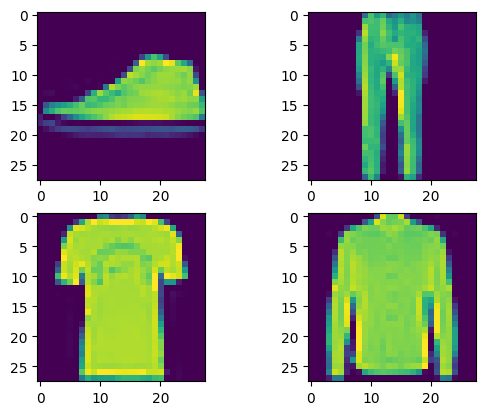

In [ ]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[41][:,:,0])

plt.subplot(222)
plt.imshow(X_train[542][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4363][:,:,0])

plt.subplot(224)
plt.imshow(X_train[8224][:,:,0])
plt.show()

**Encoder Architecture**

In [ ]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = K.int_shape(x)

In [ ]:
x = Flatten()(x)
x = Dense(32)(x)

In [ ]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

In [ ]:
def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps
  return rnd_sam

In [ ]:
z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

In [ ]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 128)          3328      ['encoder input[0][0]']       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 14, 14, 64)           73792     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_5[0][0]']            
                                                                                            

**Decoder Architecture**

In [ ]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

In [ ]:
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_1 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 64)        3692

**Model Training**

In [ ]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)

vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 552548    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         356545    
                                                                 
Total params: 909093 (3.47 MB)
Trainable params: 909093 (3.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))

In [ ]:
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
1875/1875 [==============================] - 30s 14ms/step - loss: 8.5679 - val_loss: 7.6468
Epoch 2/20
1875/1875 [==============================] - 23s 12ms/step - loss: 7.5899 - val_loss: 7.5305
Epoch 3/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.4876 - val_loss: 7.4382
Epoch 4/20
1875/1875 [==============================] - 23s 13ms/step - loss: 7.4090 - val_loss: 7.3811
Epoch 5/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.3550 - val_loss: 7.3205
Epoch 6/20
1875/1875 [==============================] - 23s 12ms/step - loss: 7.3096 - val_loss: 7.2773
Epoch 7/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.2751 - val_loss: 7.2346
Epoch 8/20
1875/1875 [==============================] - 24s 13ms/step - loss: 7.2423 - val_loss: 7.2205
Epoch 9/20
1875/1875 [==============================] - 22s 12ms/step - loss: 7.2107 - val_loss: 7.1897
Epoch 10/20
1875/1875 [==============================] - 23s 12m

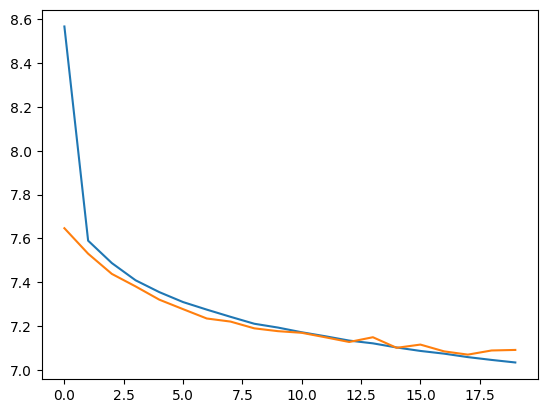

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Test Sample**

313/313 [==============================] - 1s 4ms/step


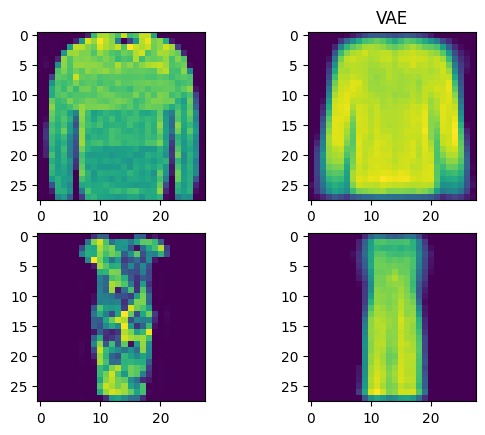

In [ ]:
index = 20

y_pred = vae.predict(X_test)

plt.figure(1)
plt.subplot(221)
plt.imshow(X_test[index].reshape(28,28))

plt.subplot(222)
plt.title('VAE')
plt.imshow(y_pred[index].reshape(28,28))

plt.subplot(223)
plt.imshow(X_test[index*5].reshape(28,28))

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28))
plt.show()